# **Amazon's Reviews Analysis**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Management Data
import tarfile
import gzip
import shutil
from shutil import copyfile

import warnings
import pandas as pd
import numpy as np

# Preprocessing Data
import os
import string
import collections
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from collections import Counter
nltk.download('stopwords')
nltk.download('wordnet')

# Text Representation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Text Classification
from sklearn.metrics import (precision_recall_curve, auc, confusion_matrix,
                             f1_score, fbeta_score, precision_score,
                             recall_score, classification_report)
import itertools
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# Neural Network tools
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import Input
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import SGD, Adadelta, Adam
from tensorflow.keras import regularizers
from keras.models import Model

# Clustering
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics.pairwise import pairwise_distances_chunked
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.patches as mpatches
import scipy.spatial.distance as scdist
from sklearn import metrics

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# Copia file gzip in runtime
path = '/path/to/file'
copyfile(path + 'amazon_review_full_csv.tar.gz',
         'amazon_review_full_csv.tar.gz')

# Unzip di file gzip e salvataggio in file tar
with gzip.open('amazon_review_full_csv.tar.gz', 'rb') as f_in:
    with open('amazon_review_full_csv.tar', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# Estrazione contenuto file tar
tar = tarfile.open('amazon_review_full_csv.tar')
tar.extractall()
tar.close()

In [ ]:
train = pd.read_csv('/content/amazon_review_full_csv/train.csv', 
                   names=['label', 'title', 'text'], header=None)
test = pd.read_csv('/content/amazon_review_full_csv/test.csv', 
                   names=['label', 'title', 'text'], header=None)

In [ ]:
print("Dimensione train set:", train.shape)
print("Dimensione test set:", test.shape)

Dimensione train set: (3000000, 3)
Dimensione test set: (650000, 3)


In [ ]:
train.head()

,label,title,text
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


In [ ]:
train = train.sample(frac=0.3, random_state=42, axis=0)
test = test.sample(frac=0.3, random_state=42, axis=0)

In [ ]:
print("Dimensione train set:", train.shape)
print("Dimensione test set:", test.shape)

Dimensione train set: (900000, 3)
Dimensione test set: (195000, 3)


## Preprocessing Functions
In this section we provide a series of function useful to preprocess our data.

In [ ]:
STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in STOPWORDS])

PUNCTUATIONS = string.punctuation.replace('#','')
def remove_punctuation(text):
    trans = str.maketrans(dict.fromkeys(PUNCTUATIONS, ' '))
    return text.translate(trans)

def remove_whitespaces(text):
    return " ".join(text.split())

def remove_freqwords(text, freqwords):
    return " ".join([word for word in str(text).split() if word not in freqwords])

def remove_rarewords(text, rarewords):
    return " ".join([word for word in str(text).split() if word not in rarewords])

### Conversion Emoticons to Word
We decide to classify a series of *emoticons* as `good` or `bad` and replace the corresponding word in the text.

In [ ]:
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"<:‑\|":"Dump",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(?_?\)":"Confusion",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised"
}

In [ ]:
pos_emot = ['Happy face or smiley', 'Happy face smiley', 'Laughing, big grin or laugh with glasses', 
       'Very happy', 'Tears of happiness', 'Suprise', 'Kiss','Shock', 'Wink or smirk',
       'Tongue sticking out', 'cheeky', 'playful or blowing a raspberry','Angel', 
       'saint or innocent', 'Baby', 'Sleeping', 'Wink', 'Confused','Ultraman', 
       'Joyful', 'Normal Laugh', 'Waving', 'Excited', 'Amazed','Laughing,Cheerful',
       'Headphones','Listening to music','Eyeglasses', 'Happy', 'Surprised',
       "Tongue sticking out, cheeky, playful or blowing a raspberry"]
neg_emot = ['Frown, sad, andry or pouting', 'Crying', 'Horror', 'Disgust', 'Sadness',
       'Yawn','Grat dismay', 'Skeptical, annoyed, undecided, uneasy or hesitant',
       'Straight face','Sealed lips or wearing braces or tongue-tied','Being sick',
       'Dump', 'Troubled', 'Nervous or Embarrassed or Troubled or Shy or Sweat drop', 
       'Sad of Crying', 'Shame', 'Confusion', 'Worried']

In [ ]:
def convert_emoticons(text):
  for emot in EMOTICONS:
    if EMOTICONS[emot] in pos_emot:
      text = re.sub(u'('+emot+')', 'good', text)
    else:
      text = re.sub(u'('+emot+')', 'bad', text)
  return text

### Conversion Emoji to Word and Remotion of Neutrals
We decide to classify a series of *emoji* as `good` or `bad` and replace the corresponding word in the text.

In [ ]:
pos_emoji = ['\U0001F601', '\U0001F602', '\U0001F603', '\U0001F604',
             '\U0001F605', '\U0001F606', '\U0001F609', '\U0001F60A',
             '\U0001F60B', '\U0001F60C', '\U0001F60D', '\U0001F60F',
             '\U0001F618', '\U0001F61A', '\U0001F61C', '\U0001F61D',
             '\U0001F64C', '\U0001F600', '\U0001F607', '\U0001F60E',
             '\U0001F525', '\U0001F44D', '\U0001F4AA', '\U0001F4AF']

neg_emoji = ['\U0001F612', '\U0001F613', '\U0001F614', '\U0001F616',
             '\U0001F61E', '\U0001F620', '\U0001F621', '\U0001F622',
             '\U0001F623', '\U0001F624', '\U0001F625', '\U0001F628',
             '\U0001F629', '\U0001F62A', '\U0001F62B', '\U0001F62D',
             '\U0001F630', '\U0001F631', '\U0001F632', '\U0001F633',
             '\U0001F635', '\U0001F637', '\U0001F645', '\U0001F610',
             '\U0001F611', '\U0001F615', '\U0001F61F', '\U0001F626',
             '\U0001F627', '\U0001F4A9', '\U0001F44E']

In [ ]:
def convert_emoji(text):
    for emot in pos_emoji:
        text = re.sub(r'('+emot+')', 'good', text)
    for emot in neg_emoji:
      text = re.sub(r'('+emot+')', 'bad', text)
    return text

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

### Decontraction of Words
Expansion of colloquial/slang expressions (e.g. '*imo*' corresponds to '*in my opinion*') and expansion of contractions (e.g. '*won't*' corresponds to '*will not*').

In [ ]:
slangs_str = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you
ILU=ILU: I Love You
IMHO=In My Honest Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My Aaa Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The Ass
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My Ass Off
SK8=Skate
STATS=Your sex and age
ASL=Age Sex Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The Fuck
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait
"""
# Built dictionary
slangs_map_dict = {}
slangs_list = []
for line in slangs_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        slangs_list.append(cw)
        slangs_map_dict[cw] = cw_expanded
slangs_list = set(slangs_list)

In [ ]:
def slang_conversion(text):
  new_text = []
  for w in text.split():
      if w.upper() in slangs_list:
          new_text.append(slangs_map_dict[w.upper()].lower())
      else:
          new_text.append(w)
  return " ".join(new_text)


In [ ]:
def decontracted(phrase):
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)
  phrase = re.sub(r"let\'s", "let us", phrase)
  phrase = re.sub(r"\'cause", "because", phrase)
  phrase = re.sub(r"shan\'t", "shall not", phrase)
  phrase = re.sub(r"o\'clock", "of the clock", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase

In [ ]:
def pre_processing(data):

  # Add Boolean Column
  data["positive"] = data.label > 3
  # To Lower Case
  data['preprocessed'] = data.text.str.lower()
  # Remove Url Link
  data.preprocessed = data.preprocessed.str.replace(r'https?://\S+|www\.\S+',
                                                    '', regex=True)
  # Convert Emoticons
  data.preprocessed = data.preprocessed.apply(lambda text: convert_emoticons(
      text))
  # Convert Emoji
  data.preprocessed = data.preprocessed.apply(lambda text: convert_emojis(
      text))
  # Remove Emoji
  data.preprocessed = data.preprocessed.apply(lambda text: remove_emoji(text))
  # Decontract Slang
  data.preprocessed = data.preprocessed.apply(lambda text: slang_conversion(
      text))
  # Decontract Phrases
  data.preprocessed = data.preprocessed.apply(lambda text: decontracted(text))
  # Remove Numeric
  data.preprocessed = data.preprocessed.str.replace(r'\d+', '', regex=True)
  # Remove Stop Words
  data.preprocessed = data.preprocessed.apply(lambda text: remove_stopwords(
      text))
  # Frequent and Rare Words
  cnt = Counter()
  for text in data["preprocessed"].values:
    for word in text.split():
        cnt[word] += 1
  freqwords = set([w for (w, wc) in cnt.most_common(20)])
  n_rarewords = 50
  rarewords = set([w for (w, wc) in cnt.most_common()[:-n_rarewords-1:-1]])
  data.preprocessed = data.preprocessed.apply(lambda text: remove_freqwords(
      text, freqwords))
  data.preprocessed = data.preprocessed.apply(lambda text: remove_rarewords(
      text, rarewords))
  # Remove Puntuaction
  data.preprocessed = data.preprocessed.apply(lambda text: remove_punctuation(
      text))
  # Remove Blank Spaces
  data.preprocessed = data.preprocessed.apply(lambda text: remove_whitespaces(
      text))
  # Remove Empty Rows
  data = data[~data.preprocessed.str.contains(r"^\s*$")]

  return data

### Application of preprocessing on train and test data


In [ ]:
train = pre_processing(train)
test = pre_processing(test)

In [ ]:
train.preprocessed.head()

2945667    really give three half stars forced round off ...
2352586    mmmmmmm love balm smells divine makes skin vel...
1531260    pitch black plays perfectly reason chronicles ...
941910     currently slim fast diet found better expected...
2582125    much writing reviews brief rack best market wh...
Name: preprocessed, dtype: object

### Lemmatization & Stemming

In [ ]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
def lemmaSentence(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

train['lemmatized'] = train.preprocessed.apply(lambda text: lemmaSentence(text))
test['lemmatized'] = test.preprocessed.apply(lambda text: lemmaSentence(text))

In [ ]:
train.head()

,label,title,text,positive,preprocessed,lemmatized
2945667,4,Not Koontz's best but good read.,"Really, I should give it three and a half star...",True,really give three half stars forced round off ...,really give three half star forced round off w...
2352586,4,addictive--except for the price,mmmmmmm. Love this balm. Smells divine and mak...,True,mmmmmmm love balm smells divine makes skin vel...,mmmmmmm love balm smell divine make skin velve...
1531260,2,Same problem,"Pitch Black plays perfectly, but for some reas...",False,pitch black plays perfectly reason chronicles ...,pitch black play perfectly reason chronicle st...
941910,1,Just say no to Slim-fast low carb shakes,I am currently on a Slim-fast diet and found i...,False,currently slim fast diet found better expected...,currently slim fast diet found better expected...
2582125,5,Happy Thanksgiving Turkey,I'm not much on writing reviews so I will be b...,True,much writing reviews brief rack best market wh...,much writing review brief rack best market why...


In [ ]:
# Stemming
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

train['stemmed'] = train.preprocessed.apply(lambda text: stem_words(text))
test['stemmed'] = test.preprocessed.apply(lambda text: stem_words(text))

In [ ]:
train.head()

,label,title,text,positive,preprocessed,lemmatized,stemmed
2945667,4,Not Koontz's best but good read.,"Really, I should give it three and a half star...",True,really give three half stars forced round off ...,really give three half star forced round off w...,realli give three half star forc round off war...
2352586,4,addictive--except for the price,mmmmmmm. Love this balm. Smells divine and mak...,True,mmmmmmm love balm smells divine makes skin vel...,mmmmmmm love balm smell divine make skin velve...,mmmmmmm love balm smell divin make skin velvet...
1531260,2,Same problem,"Pitch Black plays perfectly, but for some reas...",False,pitch black plays perfectly reason chronicles ...,pitch black play perfectly reason chronicle st...,pitch black play perfectli reason chronicl sti...
941910,1,Just say no to Slim-fast low carb shakes,I am currently on a Slim-fast diet and found i...,False,currently slim fast diet found better expected...,currently slim fast diet found better expected...,current slim fast diet found better expect tam...
2582125,5,Happy Thanksgiving Turkey,I'm not much on writing reviews so I will be b...,True,much writing reviews brief rack best market wh...,much writing review brief rack best market why...,much write review brief rack best market whi t...


## Splitting Data into Target and Features


In [ ]:
# Preprocessed text
x_train = train.preprocessed.values
x_test = test.preprocessed.values

# Lemmatized text
x_train_lm = train.lemmatized.values
x_test_lm = test.lemmatized.values

# Stemmed text (Porter)
x_train_st = train.stemmed.values
x_test_st = test.stemmed.values

# Target labels
y_train = train.positive.values
y_test = test.positive.values

In [ ]:
train.groupby("positive").size()

positive
False    539944
True     360054
dtype: int64

In [ ]:
test.groupby("positive").size()

positive
False    117083
True      77917
dtype: int64

In [ ]:
train.groupby("positive").size()/(train.shape[0])

positive
False    0.599939
True     0.400061
dtype: float64

In [ ]:
test.groupby("positive").size()/(test.shape[0])

positive
False    0.600426
True     0.399574
dtype: float64

## Document Representation for Classification with AdaBooster and MLP
We test the TF-IDF and BoW representation.

In [ ]:
# Tf-Idf representation
tfidf_vect = TfidfVectorizer(max_features = 1000)

# Preprocessed data
x_train_tfidf = tfidf_vect.fit_transform(x_train)
x_test_tfidf = tfidf_vect.transform(x_test)

# Lemmatized data
x_train_tfidf_lm = tfidf_vect.fit_transform(x_train_lm)
x_test_tfidf_lm = tfidf_vect.transform(x_test_lm)

# Stemmed data
x_train_tfidf_st = tfidf_vect.fit_transform(x_train_st)
x_test_tfidf_st = tfidf_vect.transform(x_test_st)

In [ ]:
# Bow Representation
count_vec = CountVectorizer(ngram_range=(1,1), max_features = 1000)

# Preprocessed data
x_train_bow = count_vec.fit_transform(x_train)
x_test_bow = count_vec.transform(x_test)

# Lemmatized data
x_train_bow_lm = count_vec.fit_transform(x_train_lm)
x_test_bow_lm = count_vec.transform(x_test_lm)

# Stemmed data
x_train_bow_st = count_vec.fit_transform(x_train_st)
x_test_bow_st = count_vec.transform(x_test_st)

## Classification
We aim to classify Amazon's rewies as positive ($label > 3$) and negative ($label \leq 3$).
We decice to implement a simple NN in order to achieve our task.
We tested two different classifier in this phase: AdaBoost Classifier and MLP. We executed 6 classification for each classifier: the 3 data preoprocessing with TF-IDF and with BoW.

In [ ]:
def score_model(clf, X_train, X_test, y_train, y_test):
  
  train_score = clf.score(X_train, y_train) 
  test_score = clf.score(X_test, y_test)    

  predictions = clf.predict(X_test)

  prec = precision_score(y_test, predictions)
  rec = recall_score(y_test, predictions)
  f1 = f1_score(y_test, predictions) # F1
  f2 = fbeta_score(y_test, predictions, beta=2) # F2
  cm = confusion_matrix(y_test, predictions)
  scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                    "Test Recall", "Test F1", "Test F2"]

  scores = [train_score, test_score, prec, rec, f1, f2]

  print(("{:20s} {:.5f}\n"*6)[:-1].format(
      *itertools.chain(*zip(scores_strings, scores))))
  print("Classification report:")
  print(classification_report(y_test, predictions, digits=5))

In [ ]:
def fit_score(clf, x_train, x_test, y_train = y_train, y_test = y_test):
  clf.fit(x_train, y_train)
  return score_model(clf, x_train, x_test, y_train, y_test)

### AdaBoostClassifier TF-IDF

In [ ]:
clf_ad= AdaBoostClassifier(n_estimators = 100, random_state=0)

In [ ]:
# Classification on preprocessed data
fit_score(clf_ad, x_train_tfidf, x_test_tfidf)

Train Accuracy       0.73130
Test Accuracy        0.73111
Test Precision       0.68757
Test Recall          0.59944
Test F1              0.64049
Test F2              0.61521
Classification report:
              precision    recall  f1-score   support

       False    0.75439   0.81874   0.78525    117083
        True    0.68757   0.59944   0.64049     77916

    accuracy                        0.73111    194999
   macro avg    0.72098   0.70909   0.71287    194999
weighted avg    0.72769   0.73111   0.72740    194999



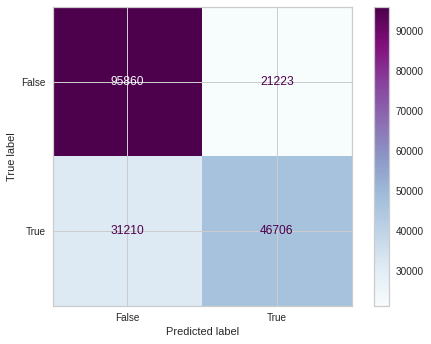

In [ ]:
warnings.filterwarnings('ignore')
plot_confusion_matrix(clf_ad, x_test_tfidf, y_test, cmap = 'BuPu')

In [ ]:
# Classification on lemmatizated data
fit_score(clf_ad, x_train_tfidf_lm, x_test_tfidf_lm)

Train Accuracy       0.73204
Test Accuracy        0.73122
Test Precision       0.69314
Test Recall          0.58736
Test F1              0.63588
Test F2              0.60585
Classification report:
              precision    recall  f1-score   support

       False    0.75072   0.82695   0.78699    117083
        True    0.69314   0.58736   0.63588     77916

    accuracy                        0.73122    194999
   macro avg    0.72193   0.70716   0.71144    194999
weighted avg    0.72771   0.73122   0.72661    194999



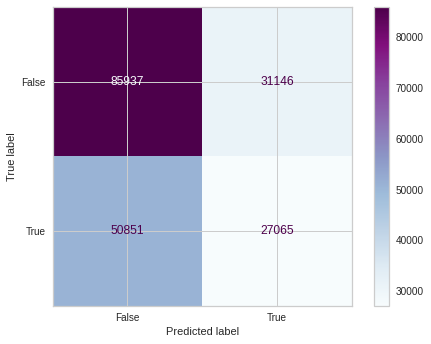

In [ ]:
warnings.filterwarnings('ignore')
plot_confusion_matrix(clf_ad, x_test_tfidf_lm, y_test, cmap = 'BuPu')

In [ ]:
# Classification on stemmed data
fit_score(clf_ad, x_train_tfidf_st, x_test_tfidf_st)

Train Accuracy       0.73667
Test Accuracy        0.73656
Test Precision       0.69671
Test Recall          0.60334
Test F1              0.64667
Test F2              0.61996
Classification report:
              precision    recall  f1-score   support

       False    0.75765   0.82522   0.78999    117083
        True    0.69671   0.60334   0.64667     77916

    accuracy                        0.73656    194999
   macro avg    0.72718   0.71428   0.71833    194999
weighted avg    0.73330   0.73656   0.73273    194999



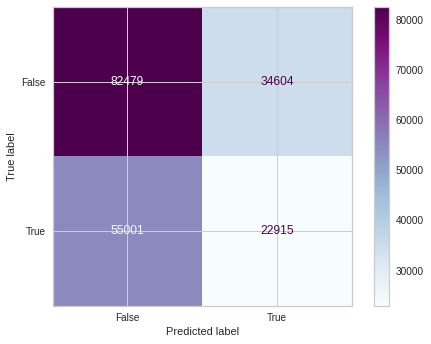

In [ ]:
warnings.filterwarnings('ignore')
plot_confusion_matrix(clf_ad, x_test_tfidf_st, y_test, cmap = 'BuPu')

### AdaBoostClassifier BoW

In [ ]:
# Classification on preprocessed data
fit_score(clf_ad, x_train_bow, x_test_bow)

Train Accuracy       0.73133
Test Accuracy        0.73117
Test Precision       0.68972
Test Recall          0.59476
Test F1              0.63873
Test F2              0.61160
Classification report:
              precision    recall  f1-score   support

       False    0.75296   0.82195   0.78594    117083
        True    0.68972   0.59476   0.63873     77916

    accuracy                        0.73117    194999
   macro avg    0.72134   0.70835   0.71233    194999
weighted avg    0.72769   0.73117   0.72712    194999



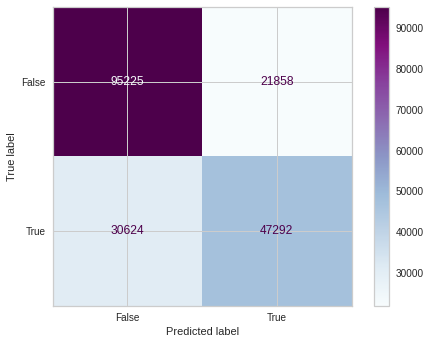

In [ ]:
warnings.filterwarnings('ignore')
plot_confusion_matrix(clf_ad, x_test_bow, y_test, cmap = 'BuPu')

In [ ]:
# Classification on lemmatizated data
fit_score(clf_ad, x_train_bow_lm, x_test_bow_lm)

Train Accuracy       0.73242
Test Accuracy        0.73170
Test Precision       0.69936
Test Recall          0.57626
Test F1              0.63187
Test F2              0.59729
Classification report:
              precision    recall  f1-score   support

       False    0.74758   0.83514   0.78894    117083
        True    0.69936   0.57626   0.63187     77916

    accuracy                        0.73170    194999
   macro avg    0.72347   0.70570   0.71040    194999
weighted avg    0.72831   0.73170   0.72618    194999



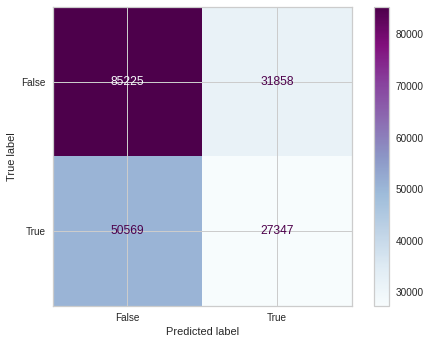

In [ ]:
warnings.filterwarnings('ignore')
plot_confusion_matrix(clf_ad, x_test_bow_lm, y_test, cmap = 'BuPu')

Train Accuracy       0.73679
Test Accuracy        0.73733
Test Precision       0.69562
Test Recall          0.60917
Test F1              0.64953
Test F2              0.62470
Classification report:
              precision    recall  f1-score   support

       False    0.75978   0.82261   0.78995    117083
        True    0.69562   0.60917   0.64953     77916

    accuracy                        0.73733    194999
   macro avg    0.72770   0.71589   0.71974    194999
weighted avg    0.73414   0.73733   0.73384    194999



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



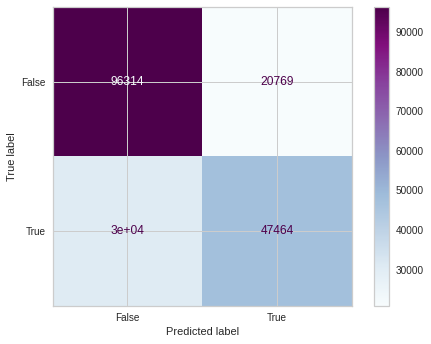

In [ ]:
# Classification on stemmed data
fit_score(clf_ad, x_train_bow_st, x_test_bow_st)

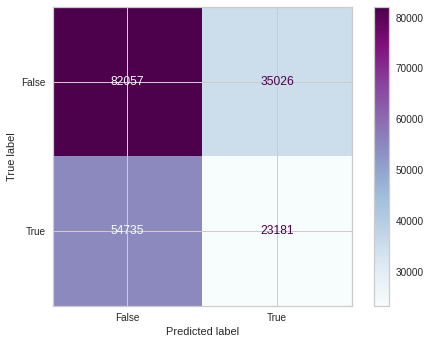

In [ ]:
warnings.filterwarnings('ignore')
plot_confusion_matrix(clf_ad, x_test_bow_st, y_test, cmap = 'BuPu')

### Multi Layer Perceptron TF-IDF

In [ ]:
clf_mlp = MLPClassifier(activation = 'relu', solver='adam',
                        hidden_layer_sizes=(5, 2), random_state = 1)

In [ ]:
# Classification on preprocessed data
fit_score(clf_mlp, x_train_tfidf, x_test_tfidf)

Train Accuracy       0.78256
Test Accuracy        0.77834
Test Precision       0.74142
Test Recall          0.68371
Test F1              0.71140
Test F2              0.69452
Classification report:
              precision    recall  f1-score   support

       False    0.79988   0.84132   0.82008    117083
        True    0.74142   0.68371   0.71140     77916

    accuracy                        0.77834    194999
   macro avg    0.77065   0.76251   0.76574    194999
weighted avg    0.77652   0.77834   0.77665    194999



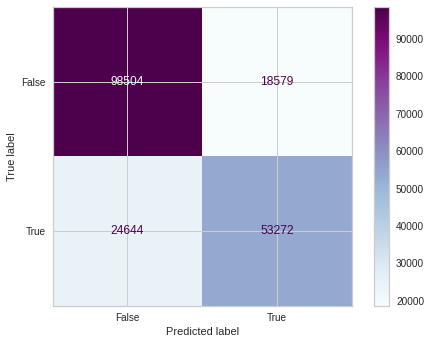

In [ ]:
warnings.filterwarnings('ignore')
plot_confusion_matrix(clf_mlp, x_test_tfidf, y_test, cmap = 'BuPu')

In [ ]:
# Classification on lemmatizated data
fit_score(clf_mlp, x_train_tfidf_lm, x_test_tfidf_lm)

Train Accuracy       0.78308
Test Accuracy        0.77869
Test Precision       0.74353
Test Recall          0.68103
Test F1              0.71091
Test F2              0.69267
Classification report:
              precision    recall  f1-score   support

       False    0.79898   0.84367   0.82072    117083
        True    0.74353   0.68103   0.71091     77916

    accuracy                        0.77869    194999
   macro avg    0.77126   0.76235   0.76581    194999
weighted avg    0.77682   0.77869   0.77684    194999



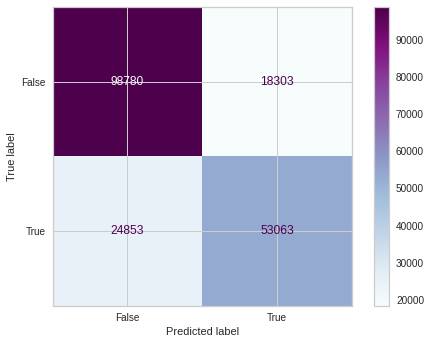

In [ ]:
warnings.filterwarnings('ignore')
plot_confusion_matrix(clf_mlp, x_test_tfidf_lm, y_test, cmap = 'BuPu')

In [ ]:
# Classification on stemmed data
fit_score(clf_mlp, x_train_tfidf_st, x_test_tfidf_st)

Train Accuracy       0.78591
Test Accuracy        0.78170
Test Precision       0.74059
Test Recall          0.69823
Test F1              0.71878
Test F2              0.70631
Classification report:
              precision    recall  f1-score   support

       False    0.80654   0.83724   0.82161    117083
        True    0.74059   0.69823   0.71878     77916

    accuracy                        0.78170    194999
   macro avg    0.77357   0.76773   0.77020    194999
weighted avg    0.78019   0.78170   0.78052    194999



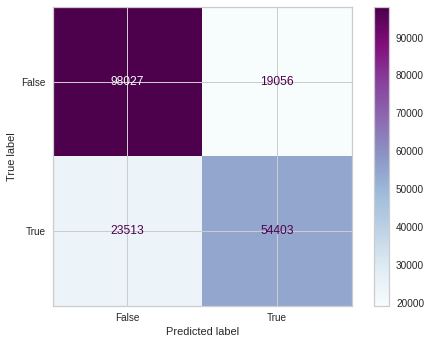

In [ ]:
warnings.filterwarnings('ignore')
plot_confusion_matrix(clf_mlp, x_test_tfidf_st, y_test, cmap = 'BuPu')

### Multi Layer Perceptron BoW

In [ ]:
# Classification on preprocessed data
fit_score(clf_mlp, x_train_bow, x_test_bow)

Train Accuracy       0.78045
Test Accuracy        0.77583
Test Precision       0.73748
Test Recall          0.68163
Test F1              0.70845
Test F2              0.69211
Classification report:
              precision    recall  f1-score   support

       False    0.79830   0.83852   0.81792    117083
        True    0.73748   0.68163   0.70845     77916

    accuracy                        0.77583    194999
   macro avg    0.76789   0.76008   0.76319    194999
weighted avg    0.77399   0.77583   0.77418    194999



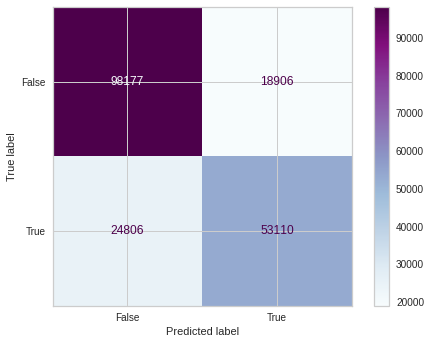

In [ ]:
warnings.filterwarnings('ignore')
plot_confusion_matrix(clf_mlp, x_test_bow, y_test, cmap = 'BuPu')

In [ ]:
# Classification on lemmatizated data
fit_score(clf_mlp, x_train_bow_lm, x_test_bow_lm)

Train Accuracy       0.78132
Test Accuracy        0.77631
Test Precision       0.73772
Test Recall          0.68298
Test F1              0.70930
Test F2              0.69327
Classification report:
              precision    recall  f1-score   support

       False    0.79896   0.83841   0.81821    117083
        True    0.73772   0.68298   0.70930     77916

    accuracy                        0.77631    194999
   macro avg    0.76834   0.76070   0.76375    194999
weighted avg    0.77449   0.77631   0.77469    194999



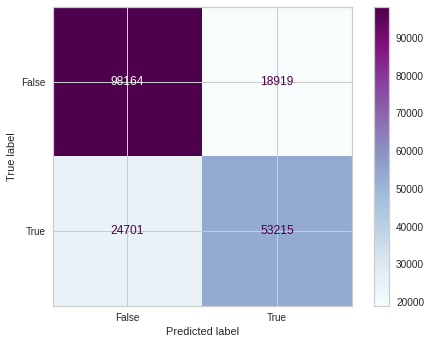

In [ ]:
warnings.filterwarnings('ignore')
plot_confusion_matrix(clf_mlp, x_test_bow_lm, y_test, cmap = 'BuPu')

In [ ]:
# Classification on stemmed data
fit_score(clf_mlp, x_train_bow_st, x_test_bow_st)

Train Accuracy       0.78444
Test Accuracy        0.78015
Test Precision       0.74540
Test Recall          0.68311
Test F1              0.71289
Test F2              0.69472
Classification report:
              precision    recall  f1-score   support

       False    0.80022   0.84473   0.82187    117083
        True    0.74540   0.68311   0.71289     77916

    accuracy                        0.78015    194999
   macro avg    0.77281   0.76392   0.76738    194999
weighted avg    0.77832   0.78015   0.77833    194999



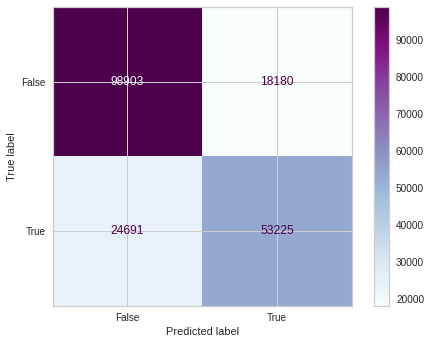

In [ ]:
warnings.filterwarnings('ignore')
plot_confusion_matrix(clf_mlp, x_test_bow_st, y_test, cmap = 'BuPu')

## Document Representation for Neural Network Classification

In [ ]:
# Splitting train-validation preprocessed text
x_train, x_val, _, _ = train_test_split(x_train, y_train,
                                        test_size=0.2,random_state=42)

# Splitting train-validation lemmatizated text
x_train_lm, x_val_lm, _, _ = train_test_split(x_train_lm, y_train,
                                              test_size=0.2, random_state=42)

# Splitting train-validation stemmed text
x_train_st, x_val_st, y_train, y_val = train_test_split(x_train_st, y_train,
                                                        test_size=0.2,
                                                        random_state=42)

In [ ]:
tfidf_vect = TfidfVectorizer(max_features = 1000)
# Preprocessed data

x_train_tfidf = tfidf_vect.fit_transform(x_train)
x_val_tfidf = tfidf_vect.fit_transform(x_val)
x_test_tfidf = tfidf_vect.transform(x_test)

# Lemmatized data
x_train_tfidf_lm = tfidf_vect.fit_transform(x_train_lm)
x_val_tfidf_lm = tfidf_vect.fit_transform(x_val_lm)
x_test_tfidf_lm = tfidf_vect.transform(x_test_lm)

# Stemmed data
x_train_tfidf_st = tfidf_vect.fit_transform(x_train_st)
x_val_tfidf_st = tfidf_vect.fit_transform(x_val_st)
x_test_tfidf_st = tfidf_vect.transform(x_test_st)

In [ ]:
print(x_train.shape)
print(x_train_tfidf.shape)
print(x_val.shape)
print(x_val_tfidf.shape)
print(x_test.shape)
print(x_test_tfidf.shape)

(719998,)
(719998, 1000)
(180000,)
(180000, 1000)
(195000,)
(195000, 1000)


In [ ]:
count_vec = CountVectorizer(ngram_range=(1,1), max_features = 1000)
# Preprocessed data
x_train_bow = count_vec.fit_transform(x_train)
x_val_bow = count_vec.fit_transform(x_val)
x_test_bow = count_vec.transform(x_test)

# Lemmatized data
x_train_bow_lm = count_vec.fit_transform(x_train_lm)
x_val_bow_lm = count_vec.fit_transform(x_val_lm)
x_test_bow_lm = count_vec.transform(x_test_lm)

# Stemmed data
x_train_bow_st = count_vec.fit_transform(x_train_st)
x_val_bow_st = count_vec.fit_transform(x_val_st)
x_test_bow_st = count_vec.transform(x_test_st)

## Classification with Neural Network
We tested a embedding neural network to see if it was better than previous classical classifiers.

In [ ]:
def plot_history(network_history, n_epochs):
  
  x_plot = list(range(1,n_epochs+1))
  plt.figure()
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(x_plot, network_history.history['loss'])
  plt.plot(x_plot, network_history.history['val_loss'])
  plt.legend(['Training', 'Validation'])

  plt.figure()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(x_plot, network_history.history['accuracy'])
  plt.plot(x_plot, network_history.history['val_accuracy'])
  plt.legend(['Training', 'Validation'], loc='lower right')
  plt.show()

In [ ]:
def sparse_matrix_to_sparse_tensor(data: tuple):
  if not type(data) is tuple:
    coo = data.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    sp_tens = tf.SparseTensor(indices, coo.data, coo.shape)
    return tf.sparse.reorder(sp_tens)
  else:
    data_tensor = tuple(sparse_matrix_to_sparse_tensor(x) for x in data)
    return data_tensor

In [ ]:
def build_model(in_shape:int, 
                show_net = False) -> keras.engine.functional.Functional:

  tf.keras.backend.clear_session()
  tf.keras.backend.reset_uids()

  # Input Layer
  input_ = Input(shape=(in_shape,), sparse=True)
  dense1 = Dense(512, activation='relu')(input_)
  drop1 = Dropout(0.3)(dense1)
  # Hidden Units
  dense2 = Dense(128, activation='PReLU', kernel_regularizer =
                regularizers.l2(0.01), bias_regularizer =
                regularizers.l2(0.01))(drop1)
  dense3 = Dense(64, activation='PReLU')(dense2)
  dense4 = Dense(8, activation='PReLU')(dense3)
  # Output Layer
  dense_out = Dense(1, activation='sigmoid')(dense4)

  # Build the network
  model = Model(inputs=input_, outputs=dense_out)

  # Compiling network
  model.compile(optimizer=SGD(0.015), loss='binary_crossentropy',
                metrics=['accuracy'])

  if show_net:
    model.summary()

  return model

In [ ]:
def train_model(model, x_train, x_val, y_train, y_val,
                n_eps = 50, btc_size = 256, show_plot = False):
  
  # Training model
  warnings.filterwarnings('ignore')
  network_history_model = model.fit(x_train, y_train, epochs=n_eps,
                                    batch_size = btc_size, verbose=0,
                                    validation_data=(x_val, y_val))
  if show_plot:
    plot_history(network_history_model, n_eps)

In [ ]:
def test_model(model, x_test, y_test):

  # Evaluating model
  evaluation_model = model.evaluate(x_test, y_test, verbose=0, return_dict=True)
  print(evaluation_model)
  
  return evaluation_model

### Deep Neural Network TF-IDF

In [ ]:
# Preprocessed sparse matrix to sparse tensor | TF-IDF
(x_train_tens,
 x_val_tens,
 x_test_tens) = sparse_matrix_to_sparse_tensor((x_train_tfidf,
                                                x_val_tfidf, x_test_tfidf))

# Lemmatized sparse matrix to sparse tensor | TF-IDF
(x_train_tens_lm,
 x_val_tens_lm,
 x_test_tens_lm) = sparse_matrix_to_sparse_tensor((x_train_tfidf_lm,
                                                   x_val_tfidf_lm,
                                                   x_test_tfidf_lm))

# Stemmed sparse matrix to sparse tensor | TF-IDF
(x_train_tens_st,
 x_val_tens_st,
 x_test_tens_st) = sparse_matrix_to_sparse_tensor((x_train_tfidf_st,
                                                   x_val_tfidf_st,
                                                   x_test_tfidf_st))

In [ ]:
# Network suited on Preprocessed data
shape_tfidf = x_train_tfidf.shape[1]
net_prep_tfidf = build_model(in_shape = shape_tfidf, show_net = True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense (Dense)               (None, 512)               512512    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65792     
                                                                 
 dense_2 (Dense)             (None, 64)                8320      
                                                                 
 dense_3 (Dense)             (None, 8)                 528       
                                                                 
 dense_4 (Dense)             (None, 1)                 9     

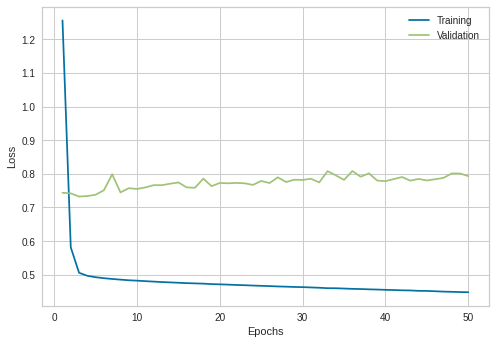

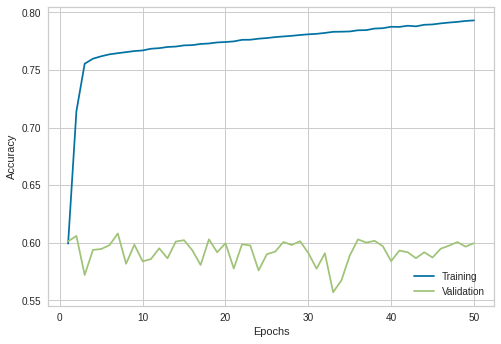

In [ ]:
train_model(net_prep_tfidf, x_train_tens, x_val_tens, y_train, y_val,
            btc_size = 128, show_plot = True)

In [ ]:
eval_prep_tfidf = test_model(net_prep_tfidf, x_test_tens, y_test)

{'loss': 0.7930805683135986, 'accuracy': 0.5990440845489502}


In [ ]:
# Network suited on Lemmatized data
net_lm_tfidf = build_model(in_shape = shape_tfidf)

In [ ]:
train_model(net_lm_tfidf, x_train_tens_lm, x_val_tens_lm, y_train, y_val,
            btc_size = 128, show_plot = True)

In [ ]:
eval_lm_tfidf = test_model(net_lm_tfidf, x_test_tens_lm, y_test)

{'loss': 2.731544017791748, 'accuracy': 0.4166790544986725}


In [ ]:
# Network suited on Stemmed data
net_st_tfidf = build_model(in_shape = shape_tfidf)

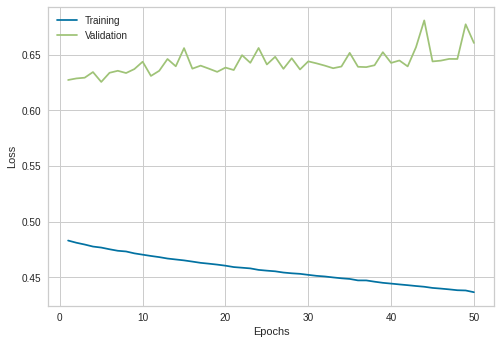

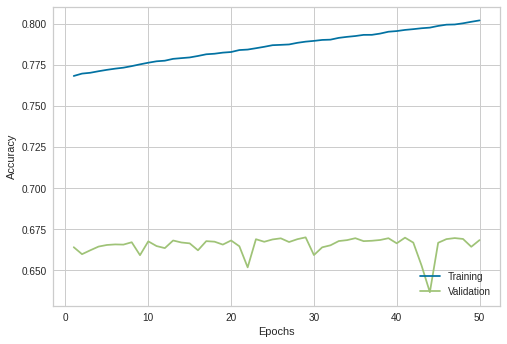

In [ ]:
train_model(net_st_tfidf, x_train_tens_st, x_val_tens_st, y_train, y_val,
            btc_size = 128, show_plot = True)

In [ ]:
eval_st_tfidf = test_model(net_st_tfidf, x_test_tens_st, y_test)

{'loss': 0.6574952006340027, 'accuracy': 0.6699419021606445}


### Deep Neural Network BoW

In [ ]:
# Preprocessed sparse matrix to sparse tensor | BoW
(x_train_tens_bow,
 x_val_tens_bow,
 x_test_tens_bow) = sparse_matrix_to_sparse_tensor((x_train_bow,
                                                    x_val_bow, x_test_bow))

# Lemmatized sparse matrix to sparse tensor | BoW
(x_train_tens_bow_lm,
 x_val_tens_bow_lm,
 x_test_tens_bow_lm) = sparse_matrix_to_sparse_tensor((x_train_bow_lm,
                                                       x_val_bow_lm,
                                                       x_test_bow_lm))

# Stemmed sparse matrix to sparse tensor | BoW
(x_train_tens_bow_st,
 x_val_tens_bow_st,
 x_test_tens_bow_st) = sparse_matrix_to_sparse_tensor((x_train_bow_st,
                                                       x_val_bow_st,
                                                       x_test_bow_st))

In [ ]:
# Network suited on Preprocessed data
shape_bow = x_train_bow.shape[1]
net_prep_bow = build_model(in_shape = shape_bow, show_net = True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense (Dense)               (None, 512)               512512    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65792     
                                                                 
 dense_2 (Dense)             (None, 64)                8320      
                                                                 
 dense_3 (Dense)             (None, 8)                 528       
                                                                 
 dense_4 (Dense)             (None, 1)                 9     

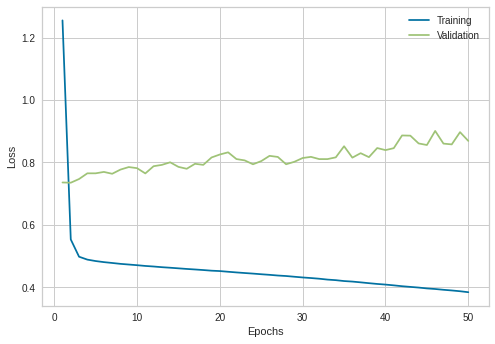

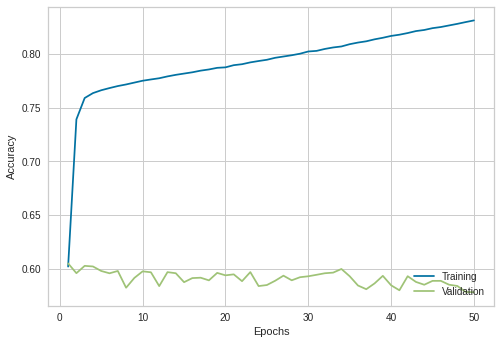

In [ ]:
train_model(net_prep_bow, x_train_tens_bow, x_val_tens_bow, y_train, y_val,
            btc_size = 128, show_plot = True)

In [ ]:
eval_prep_bow = test_model(net_prep_bow, x_test_tens_bow, y_test)

{'loss': 0.8675904273986816, 'accuracy': 0.5777773261070251}


In [ ]:
# Network suited on Lemmatized data
net_lm_bow = build_model(in_shape = shape_bow)

In [ ]:
train_model(net_lm_bow, x_train_tens_bow_lm, x_val_tens_bow_lm, y_train, y_val,
            btc_size = 128, show_plot = True)

In [ ]:
eval_lm_bow = test_model(net_lm_bow, x_test_tens_bow_lm, y_test)

In [ ]:
# Network suited on Stemmed data
net_st_bow = build_model(in_shape = shape_bow)

In [ ]:
train_model(net_st_bow, x_train_tens_bow_st, x_val_tens_bow_st, y_train, y_val,
            btc_size = 128, show_plot = True)

In [ ]:
eval_st_bow = test_model(net_st_bow, x_test_tens_bow_st, y_test)

## Clustering

In [ ]:
# We sample a subset of data, because of the computational burden
data = test.sample(n = 100000, replace = False, random_state = 1)

In [ ]:
# Preprocessed text
x = data.preprocessed.values

# Lemmatized text
x_lm = data.lemmatized.values

# Stemmed text (Porter)
x_st = data.stemmed.values

In [ ]:
# Text representation: TF-IDF
tfidf_vect = TfidfVectorizer(max_features=1000)

# Preoprocessed text
x_tfidf = tfidf_vect.fit_transform(x)

# Lemmatized text
x_tfidf_lm = tfidf_vect.fit_transform(x_lm)

# # Stemmed text
x_tfidf_st = tfidf_vect.fit_transform(x_st)

In [ ]:
# Text representation BoW
count_vec = CountVectorizer(ngram_range=(1,1), max_features = 1000)        

# Preprocessed data                   
x_bow = count_vec.fit_transform(x)

# Lemmatized data
x_bow_lm = count_vec.fit_transform(x_lm)

# Stemmed data
x_bow_st = count_vec.fit_transform(x_st)

First we perform a dimensionality reduction with SVD.

In [ ]:
# Dimensionality reduction
svd = TruncatedSVD(n_components = 2)

x_tfidf = svd.fit_transform(x_tfidf) 
x_tfidf_lm = svd.fit_transform(x_tfidf_lm) 
x_tfidf_st = svd.fit_transform(x_tfidf_st) 

x_bow = svd.fit_transform(x_bow)
x_bow_lm = svd.fit_transform(x_bow_lm) 
x_bow_st = svd.fit_transform(x_bow_st) 

We develop a function which clusters data and compute the Silhoutte score.

In [ ]:
# Clustering functions
def cluster_score(clf, data):
  clf.fit_predict(data)
  print('Silhoutte score for preprocessed data and tfidf representation:' , 
      metrics.silhouette_score(data, clf.labels_, metric='euclidean'))

### **KMeans**

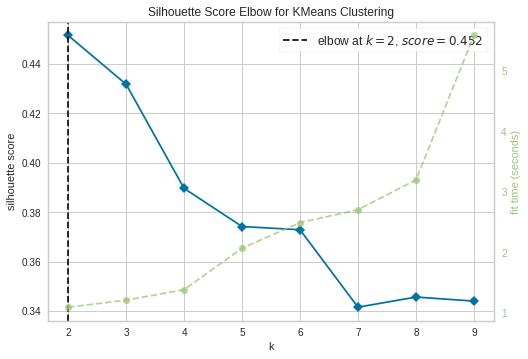

In [ ]:
# Finding the optimal number of cluster for the TF-IDF representation
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette') 

visualizer.fit(x_tfidf)
visualizer.show()

Silhouette plot:

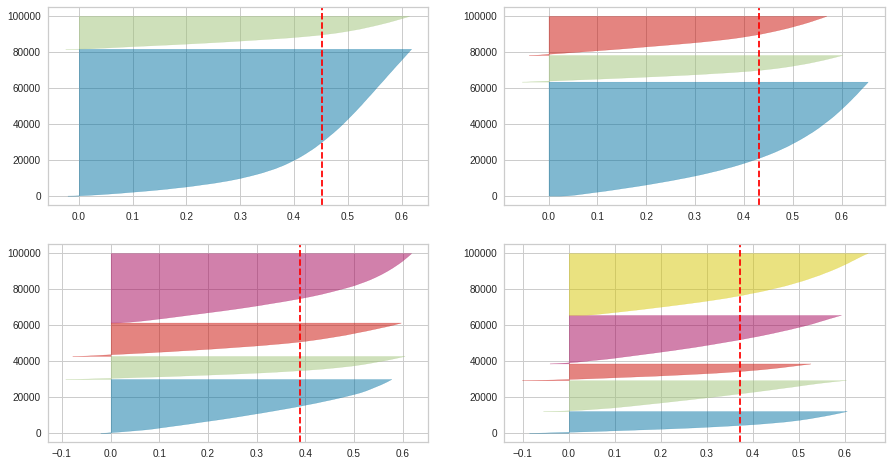

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2,3,4,5]:
    
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(x_tfidf)

In [ ]:
kmeans = KMeans(n_clusters = 2, random_state=1)
cluster_score(kmeans, x_tfidf)
cluster_score(kmeans, x_tfidf_lm)
cluster_score(kmeans, x_tfidf_st)

Silhoutte score for preprocessed data and tfidf representation: 0.4568219503850316
Silhoutte score for preprocessed data and tfidf representation: 0.6280771534487922
Silhoutte score for preprocessed data and tfidf representation: 0.6211928285661263


For confirmation, we also find the optimal number of clusters for the BoW representation.

In [ ]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette') 

visualizer.fit(x_tfidf_bow)
visualizer.show()

In [ ]:
kmeans = KMeans(n_clusters = 2, random_state=1)
cluster_score(kmeans, x_bow)
cluster_score(kmeans, x_bow_lm)
cluster_score(kmeans, x_bow_st)

Silhoutte score for preprocessed data and tfidf representation: 0.5450374489357727
Silhoutte score for preprocessed data and tfidf representation: 0.6170784438340545
Silhoutte score for preprocessed data and tfidf representation: 0.45107119264109496


### **Agglomerative Clustering**
We use the dendogram to find out the best number of cluster.
Because of the dataset dimension and the scarceness of Colab's resources, we perform the cell below in our local machine. 

In [ ]:
dendrogram = sch.dendrogram(sch.linkage(x_tfidf, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Reviews')
plt.ylabel('Euclidean distances')
plt.show()

In [ ]:
agglomerative = AgglomerativeClustering(n_clusters = 2)
cluster_score(agglomerative, x_tfidf)
cluster_score(agglomerative, x_tfidf_lm)
cluster_score(agglomerative, x_tfidf_st)

In [ ]:
cluster_score(agglomerative, x_bow)
cluster_score(agglomerative, x_bow_lm)
cluster_score(agglomerative, x_bow_st)